# Assignment 3: Exercises 6.1, 7.1, 8.1
Aaron Ou | 2018-03-04

In [1]:
rm(list = ls())
cat('\014') # clear console = Ctrl + L

### 6.1 a:

<!--(a) Estimate the minimum detectable effect for a two sided comparison of means with sample size of 440,
standard deviation of 10.2, significance level of 0.05, and power of 80%. What happens to the MDE if you increase
the sample size?
-->

In [2]:
# n = 440, sd = 10.2, sig.level = 0.05, power = 80%
power.t.test(n = 440, delta = NULL, sd = 10.2, sig.level = 0.05, power = 0.8,
             type = "two.sample",
             alternative = "two.sided",
             strict = FALSE)


     Two-sample t test power calculation 

              n = 440
          delta = 1.92873
             sd = 10.2
      sig.level = 0.05
          power = 0.8
    alternative = two.sided

NOTE: n is number in *each* group


If the sample size increases, the MDE will decrease.

### 6.1 b:

<!--
(b) Estimate the statistical power for a two sided comparison of means test with significance level of 0.10, sample
size of 20500, and standard deviation of 1010, and MDE of 250. What happens to the statistical power if you
increase the standard deviation?
-->

In [3]:
# n = 20500, sig.level  = 0.1, sd = 1010, MDE = 250
power.t.test(n = 20500, delta = 250, sd = 1010, sig.level = 0.1, power = NULL,
             type = "two.sample",
             alternative = "two.sided",
             strict = FALSE)


     Two-sample t test power calculation 

              n = 20500
          delta = 250
             sd = 1010
      sig.level = 0.1
          power = 1
    alternative = two.sided

NOTE: n is number in *each* group


If the standard deviation increases, statistical power will decrease.

### 6.1 c:

<!--
(c) Estimate the required sample size for significance level of 0.05, power of 80% standard deviation of 0.65 and MDE of .03. What happens to the required sample size when you increase the power?
-->

In [4]:
# n = NULL, sig.level = 0.05, power = 0.8, sd = 0.65, MDE = .03
power.t.test(n = NULL, sig.level = 0.05, power = 0.8, sd = 0.65, delta = 0.03,
             type = "two.sample",
             alternative = "two.sided",
             strict = FALSE)


     Two-sample t test power calculation 

              n = 7370.186
          delta = 0.03
             sd = 0.65
      sig.level = 0.05
          power = 0.8
    alternative = two.sided

NOTE: n is number in *each* group


A required sample size of 7370.
If the power increases, the required sample size will have to increase too to maintain the same MDE.

### 7.1 a:

<!--
(a) Repeat what we've done above (Graph and Sharp RD regressions) for at least two separate versions, varying the choice for the values of Z we include in the sample (band size-- something other than +-200) in one version, and the bin size in another (something other than 10). Interpret the results of the graphs and regression. What effect do the selected bin and band size have on the results?
-->

In [5]:
# Load packages needed
library(ggplot2, verbose=FALSE, warn.conflicts = FALSE, quietly = TRUE)
library(dplyr, verbose=FALSE, warn.conflicts = FALSE, quietly = TRUE)
library(miceadds, verbose=FALSE, warn.conflicts = FALSE, quietly = TRUE)
library(multiwayvcov, verbose=FALSE, warn.conflicts = FALSE, quietly = TRUE)
library(repr)

# Define a function to arrange plot for comparison
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols), byrow = TRUE)
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

* miceadds 2.9-15 (2017-12-18 11:50:04)


In [6]:
# Read raw data
d0 <- read.csv('../Data/PROGRESA_RD.csv')

In [7]:
# Define function
A71Clean <- function(band_size, bin_size) {
  #cat("---- Step 1: Clean data to get data frame d1 ----\n")
  d1 <<- d0 %>% filter(z >= -band_size, z <= band_size) %>% arrange(z) %>%
          mutate(bin0 = cut_interval(z, length = bin_size, labels = FALSE),
            bin = -(band_size + bin_size) + bin0 * bin_size,
            enroll_child = sapply(enroll_child, function(x) ifelse(x == "si", 1, 0))
            ) %>%
          select("bin", "z", "enroll_child", "pov_HH", "villid") %>% ungroup
  # print(tail(d1, 2))
  # cat("\n---- Step 2: Aggregate d1 in bin for means to get data frame r1 ----\n")
  # Aggregate data by bin. "r" means ready for plot
  r1 <<- group_by(d1, bin) %>%
          summarise(z = round(mean(z, na.rm = T), 0),
                    enroll_child = round(mean(enroll_child, na.rm = T), 2)
            ) %>% ungroup
  # print(tail(r1, 2))
}

# Cutoff (Treatment: z < 0)
A71Plot <- function(band_size, bin_size) {
  A71Clean(band_size, bin_size)
  p1 <- ggplot(r1, aes(x = bin, y = enroll_child)) +
    geom_point(color = 'blue') +
    geom_smooth(color = 'red', method = 'lm', formula = y ~ x, data = filter(r1, bin > 0)) +
    geom_smooth(color = 'green', method = 'lm', formula = y ~ x, data = filter(r1, bin < 0)) +
    xlab("z") + ylab("Child Enrollment") + 
    ggtitle(paste0("band size=", band_size, "   bin size=", bin_size)) +
    theme_linedraw()
  p1
}

A71Regression <- function(band_size, bin_size) {
  A71Clean(band_size, bin_size)
  cat(paste0("\n---- Regression model: band size=", band_size, "  bin=", bin_size, " ----\n"))
  # pov_HH = 1: below the cutoff
  model <- lm.cluster(data = d1, formula = enroll_child ~ pov_HH + z, cluster = d1$villid)
  summary(model)
  cat("\n---- Quadratic control for z, regression model ----")
  d1$z2 <- d1$z^2
  model2 <- lm.cluster(data = d1, formula = enroll_child ~ pov_HH + z + z2, cluster = d1$villid)
  summary(model2)
  cat("----------------------------------------------------------------\n")
}

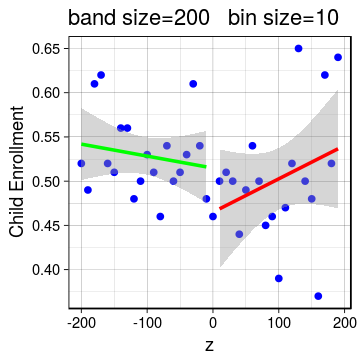

In [8]:
# Version 0 in Lab 7: band_size = 200, bin_size = 10
# Set plot size to 4 x 3
options(repr.plot.width = 3, repr.plot.height = 3)
A71Plot(200, 10)

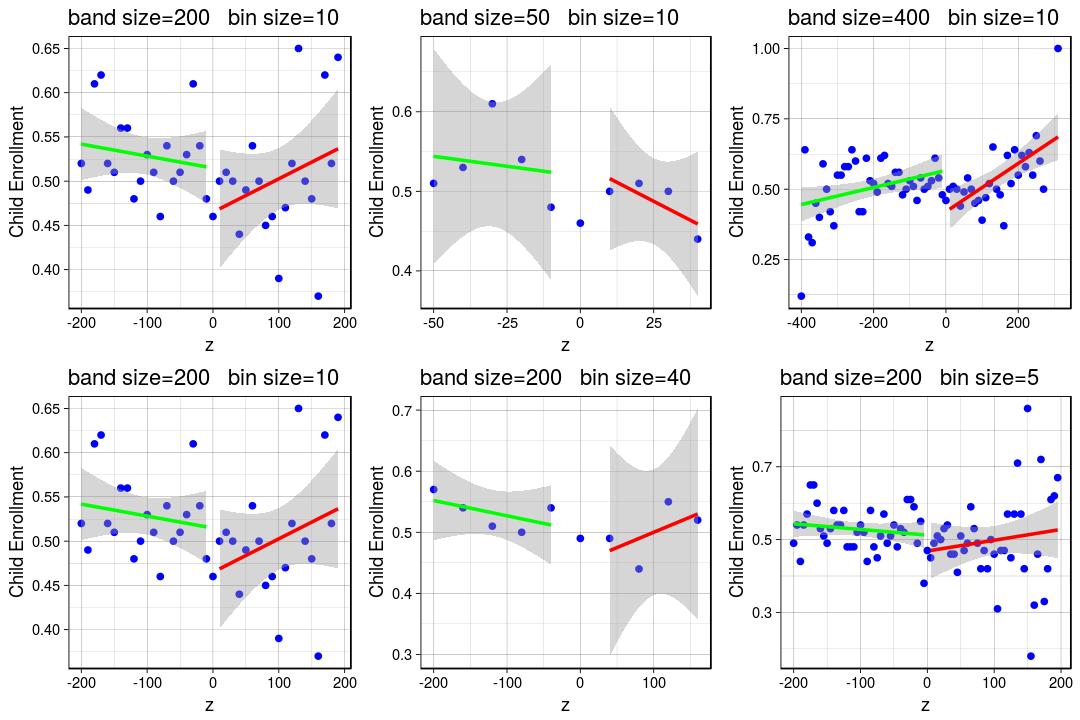

In [9]:
# Compare the plots of three versions by adjusting ban size or bin size
# Set plot size
options(repr.plot.width = 9, repr.plot.height = 6)
multiplot(
  A71Plot(200, 10), # band_size = 200, bin_size remains 10
  A71Plot(50, 10),
  A71Plot(400, 10),
    
  A71Plot(200, 10), # band_size remains 200, bin_size = 10 
  A71Plot(200, 40),
  A71Plot(200, 5),
  cols = 3)

In [10]:
# Compare the regressions of three versions by adjusting ban size or bin size
cat("============= Adjust band size at the same bin size =============")
A71Regression(200, 10)
A71Regression(50, 10)
A71Regression(400, 10)

cat("\n============= Adjust bin size  at the same band size =============")
A71Regression(200, 10)
A71Regression(200, 40)
A71Regression(200, 5)

============= Adjust band size at the same bin size =============
---- Regression model: band size=200  bin=10 ----
R^2 = 0.00119 

                 Estimate   Std. Error    t value      Pr(>|t|)
(Intercept)  4.943732e-01 0.0195547719 25.2814633 5.108385e-141
pov_HH       2.953866e-02 0.0281280015  1.0501512  2.936486e-01
z           -3.816885e-05 0.0001534685 -0.2487079  8.035867e-01

---- Quadratic control for z, regression model ----R^2 = 0.00178 

                Estimate   Std. Error    t value      Pr(>|t|)
(Intercept) 4.789523e-01 2.252099e-02 21.2669323 2.298280e-100
pov_HH      3.885764e-02 2.869374e-02  1.3542201  1.756662e-01
z           5.639947e-05 1.648254e-04  0.3421771  7.322176e-01
z2          1.285038e-06 8.800953e-07  1.4601123  1.442592e-01
----------------------------------------------------------------

---- Regression model: band size=50  bin=10 ----
R^2 = 0.00286 

                 Estimate   Std. Error    t value     Pr(>|t|)
(Intercept)  0.4959626627 0.0326682

#### Interpretation

In general, the pattern of graph and the p-value (Confidence level) of `pov_HH` under the two models are more sensitive to the change of **band size** than to the change of **bin size**.

- As **band size** increases, the p-value of `pov_HH` decreases, resulting in higher confidence level.
- No matter **bin size** increases or decreases, the graph and the regression models do not see significant change.

### 7.1 b:
<!--
(b) In the above analysis, we compare household within treatment villages. Describe at least one reason we might be concerned that a comparison of households below and above the cutoff to identify the treatment effect of PROGRESA might lead to a biased result.
-->

Reasons that might lead to a biased result:
- Household below the cutoff may live in poorer area, have less access to schools. Even when they want to enroll kids in school, they find it difficult to do so. Thus, the effect of PROGRESA may be underestimated.
- A short distance away from the cutoff may be the line of basic living standard. A family that does not have enough food may or may not prioritize kids' school enrollment. The effect of PROGRESA can be either underestimated or overestimated.
- Rich families may be families of higher education background, who understand the importance of education more and have higher enrollment rate naturally. The effect of PROGRESA can be underestimated.

### 8.1:
<!--
-->